In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1971878575991186920, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 9214062756
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16561304080512212737
 physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"]

In [3]:
import os
import numpy as np
np.random.seed(777)

import keras.backend as K
from keras.preprocessing.image import ImageDataGenerator
from sklearn.externals import joblib
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report

import sklearn
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from PIL import Image
from sklearn.model_selection import KFold, train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier

from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [4]:
img_height, img_width = 224, 224

nb_train_samples = 386
nb_validation_samples = 199
nb_test_samples = 155

In [5]:
train_dir = 'data_reduced/train/'
validation_dir = 'data_reduced/validation'
test_dir = 'data_reduced/test'

In [6]:
random_seed = np.random.seed(777)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size = 1,
    seed = random_seed,
    shuffle = True,
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size = 1,
    seed = random_seed,
    shuffle = True,
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=1,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 386 images belonging to 2 classes.
Found 199 images belonging to 2 classes.
Found 155 images belonging to 2 classes.


In [7]:
X_train, y_train = [], []
for _ in tqdm(range(nb_train_samples)):
    x, y = train_generator.next()
    X_train.append(x[0])
    y_train.append(y[0])
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
y_train = np.argmax(y_train, axis=1)
# np.save('data/npy/X_train.npy', X_train)
# np.save('data/npy/y_train.npy', y_train)

100%|███████████████████████████████████████████████████████████████████████████████| 386/386 [00:00<00:00, 402.49it/s]


In [8]:
X_train = np.array([x.flatten() for x in X_train])

In [9]:
X_validation, y_validation = [], []
for _ in tqdm(range(nb_validation_samples)):
    x_val, y_val = validation_generator.next()
    X_validation.append(x_val[0])
    y_validation.append(y_val[0])
X_validation = np.asarray(X_validation)
y_validation = np.asarray(y_validation)
y_validation = np.argmax(y_validation, axis=1)
# np.save('data/npy/X_validation.npy', X_validation)
# np.save('data/npy/y_validation.npy', y_validation)

100%|███████████████████████████████████████████████████████████████████████████████| 199/199 [00:00<00:00, 440.71it/s]


In [10]:
X_validation = np.array([x.flatten() for x in X_validation])

In [11]:
X_test, y_test = [], []
for _ in tqdm(range(nb_test_samples)):
    x_t, y_t = test_generator.next()
    X_test.append(x_t[0])
    y_test.append(y_t[0])
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)
y_test = np.argmax(y_test, axis=1)
# np.save('data/npy/X_test.npy', X_test)
# np.save('data/npy/y_test.npy', y_test)

100%|███████████████████████████████████████████████████████████████████████████████| 155/155 [00:00<00:00, 427.43it/s]


In [12]:
X_test = np.array([x.flatten() for x in X_test])

In [13]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_validation shape:", X_validation.shape)
print("y_validation shape:", y_validation.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
# plt.imshow(X_train[0])
# plt.show()

X_train shape: (386, 150528)
y_train shape: (386,)
X_validation shape: (199, 150528)
y_validation shape: (199,)
X_test shape: (155, 150528)
y_test shape: (155,)


____

In [20]:
models={}

models['XGB']= xgb.XGBClassifier()
models['SVM']= SVC(C=100)

In [22]:
num_folds = 10
seed = 777

scoring = 'accuracy'

results=[]
for key in models:
    kfold=KFold(n_splits=num_folds,random_state=seed)
    cv_result=cross_val_score(models[key],X_train,y_train,cv=kfold,scoring=scoring)
    results.append(cv_result)
    print('%s:%f(%f)'%(key,cv_result.mean(),cv_result.std()))

SVM:0.953104(0.030672)
XGB:0.935155(0.040642)


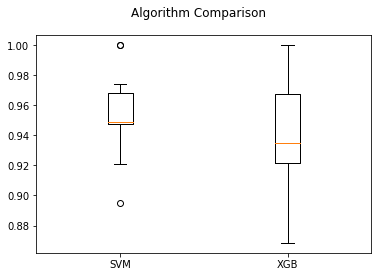

In [23]:
fig=plt.figure()
fig.suptitle('Algorithm Comparison')
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(models.keys())
plt.show()

## XGBoost Classifier

In [14]:
import xgboost as xgb

xb = xgb.XGBClassifier()
xb.fit(X_train, y_train)
# xb.score(feat_train,np.argmax(y_train,axis=1))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [15]:
y_pred = xb.predict(X_test)

In [16]:
cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred, normalize=True, sample_weight=None)
cr = classification_report(y_test, y_pred)

In [17]:
print(acc)

0.5548387096774193


In [18]:
print(cr)

              precision    recall  f1-score   support

           0       0.98      0.38      0.54       109
           1       0.40      0.98      0.57        46

   micro avg       0.55      0.55      0.55       155
   macro avg       0.69      0.68      0.55       155
weighted avg       0.80      0.55      0.55       155



In [19]:
print(cm)

[[41 68]
 [ 1 45]]
